In [1]:
import os
import pandas as pd

/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 1. 设置文件夹路径
folder_path = 'national_summary'  # 请替换为你的实际路径

# 2. 获取所有txt文件的列表
file_list = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# 3. 初始化数据列表
data = []


In [3]:
# 4. 遍历每个文件
for filename in file_list:
    file_path = os.path.join(folder_path, filename)
    
    # 读取文件内容
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # 提取日期信息
    base_name = os.path.splitext(filename)[0]
    parts = base_name.split('_')
    
    if len(parts) >= 2:
        date_str = parts[-1]  # 取最后一部分，日期字符串
        try:
            if len(date_str) == 8:
                # 格式为YYYYMMDD
                date = pd.to_datetime(date_str, format='%Y%m%d')
            elif len(date_str) == 6:
                # 格式为YYYYMM，设为当月第一天
                date = pd.to_datetime(date_str, format='%Y%m')
            else:
                print(f"未知的日期格式：{date_str}，文件名：{filename}")
                date = None
        except ValueError:
            print(f"无法解析日期：{date_str}，文件名：{filename}")
            date = None
    else:
        print(f"文件名格式不匹配，无法提取日期：{filename}")
        date = None
    
    # 添加到数据列表
    data.append({'date': date, 'content': content})

In [4]:
# 5. 转换为DataFrame
df = pd.DataFrame(data)

# 6. 按日期排序
df = df.sort_values('date').reset_index(drop=True)

# 7. 查看数据
print(df.head())

        date                                            content
0 1996-10-30  Prepared at the Federal Reserve Bank of Minnea...
1 1996-12-04  Prepared at the Federal Reserve Bank of Philad...
2 1997-01-22  Prepared at the Federal Reserve Bank of Atlant...
3 1997-03-12  Prepared at the Federal Reserve Bank of St. Lo...
4 1997-05-07  Prepared at the Federal Reserve Bank of Chicag...


In [5]:
import pandas as pd
import re
import nltk

In [6]:
nltk.download('punkt')        # 用于分词
nltk.download('stopwords')    # 停用词
nltk.download('wordnet')      # 词形还原
nltk.download('omw-1.4')      # 词形还原词典

[nltk_data] Downloading package punkt to /Users/wooxoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wooxoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/wooxoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/wooxoo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # 1. 转换为小写
    text = text.lower()
    
    # 2. 去除特殊字符和数字
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. 分词
    words = nltk.word_tokenize(text)
    
    # 4. 去除停用词
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # 5. 词形还原
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # 将词列表重新组合为字符串
    return ' '.join(words)


In [8]:
df['clean_content'] = df['content'].apply(preprocess_text)
print(df[['date', 'clean_content']].head())

        date                                      clean_content
0 1996-10-30  prepared federal reserve bank minneapolis base...
1 1996-12-04  prepared federal reserve bank philadelphia bas...
2 1997-01-22  prepared federal reserve bank atlanta based in...
3 1997-03-12  prepared federal reserve bank st louis based i...
4 1997-05-07  prepared federal reserve bank chicago based in...


In [9]:
#验证预处理效果
# 显示前5条预处理后的文本
for idx, row in df.head().iterrows():
    print(f"Date: {row['date']}")
    print(f"Original Content: {row['content'][:100]}...")  # 显示前100个字符
    print(f"Cleaned Content: {row['clean_content'][:100]}...")
    print('-' * 80)

Date: 1996-10-30 00:00:00
Original Content: Prepared at the Federal Reserve Bank of Minneapolis based on information collected before October 22...
Cleaned Content: prepared federal reserve bank minneapolis based information collected october document summarizes co...
--------------------------------------------------------------------------------
Date: 1996-12-04 00:00:00
Original Content: Prepared at the Federal Reserve Bank of Philadelphia based on

information collected before November...
Cleaned Content: prepared federal reserve bank philadelphia based information collected november document summarizes ...
--------------------------------------------------------------------------------
Date: 1997-01-22 00:00:00
Original Content: Prepared at the Federal Reserve Bank of Atlanta and based on information collected before October 20...
Cleaned Content: prepared federal reserve bank atlanta based information collected october document summarizes commen...
-------------------------------

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 加载 FinBERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")


In [11]:
def sentiment_score_finbert(text):
    # 对文本进行编码
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # 获取模型输出
    outputs = model(**inputs)
    # 获取预测的情感类别
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # 获取正面、负面和中性得分
    positive_score = probs[0][0].item()
    negative_score = probs[0][1].item()
    neutral_score = probs[0][2].item()
    # 返回结果字典
    return {
        'positive': positive_score,
        'negative': negative_score,
        'neutral': neutral_score
    }


In [12]:
# 定义一个函数，获取综合情感得分
def get_compound_score(sentiment_dict):
    # 可以根据需要定义自己的综合得分计算方式
    # 例如，正面得分减去负面得分
    compound_score = sentiment_dict['positive'] - sentiment_dict['negative']
    return compound_score

# 应用情感分析函数到 DataFrame
df['sentiment_dict'] = df['clean_content'].apply(sentiment_score_finbert)
df['sentiment'] = df['sentiment_dict'].apply(get_compound_score)

In [16]:

df[['date', 'sentiment', 'sentiment_dict']].to_csv('sentiment.csv', index=False)
print(df[['date', 'sentiment', 'sentiment_dict']].head())


        date  sentiment                                     sentiment_dict
0 1996-10-30   0.028881  {'positive': 0.1624157875776291, 'negative': 0...
1 1996-12-04  -0.588398  {'positive': 0.07799529284238815, 'negative': ...
2 1997-01-22   0.123663  {'positive': 0.17666494846343994, 'negative': ...
3 1997-03-12  -0.728463  {'positive': 0.02856595441699028, 'negative': ...
4 1997-05-07  -0.035630  {'positive': 0.16252721846103668, 'negative': ...


In [14]:
import matplotlib.pyplot as plt


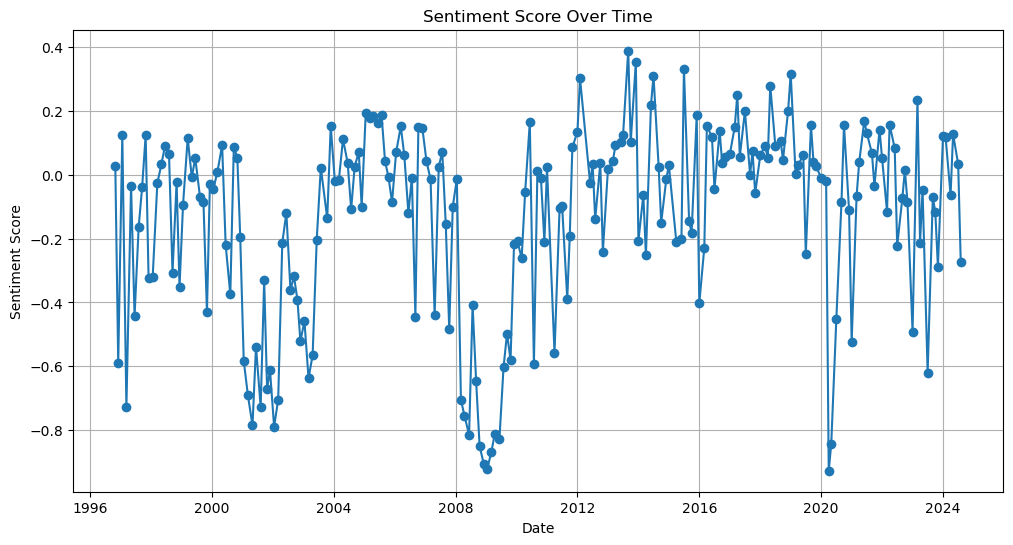

In [15]:
# 确保'date'列为日期类型
df['date'] = pd.to_datetime(df['date'])

# 按日期排序
df = df.sort_values('date').reset_index(drop=True)

# 绘制情感得分的时间序列图
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['sentiment'], marker='o')
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()